In [1]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

In [2]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('file:/home/cloudera/epri/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [3]:
df.count()

1587257

In [4]:
filteredDF = df.filter((df.rowID % 100) == 0)
filteredDF.count()

15873

In [5]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,15873,793600.0,458228.4746717515,0,1587200
air_pressure,15873,916.8291627291587,3.0517222151797943,905.1,929.4
air_temp,15873,61.854689094688936,11.83541379082148,32.36,96.44
avg_wind_direction,15870,161.2875236294896,95.3131612965649,0.0,359.0
avg_wind_speed,15870,2.7928040327662296,2.0705061984600173,0.1,20.1
max_wind_direction,15870,162.70094517958412,92.26960112663167,0.0,359.0
max_wind_speed,15870,3.41462507876495,2.428906406812135,0.1,20.9
min_wind_direction,15870,166.64429741650915,97.82483630682509,0.0,359.0
min_wind_speed,15870,2.1522684310018896,1.7581135042599596,0.0,19.5


In [6]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count() 

15786

In [7]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [8]:
workingDF = workingDF.na.drop()

In [9]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [10]:
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [11]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [12]:
scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [13]:
clusters = range(5,20)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 5 
......................WSSE = 9238.981085649033 
Training for cluster size 6 
......................WSSE = 8527.411882274308 
Training for cluster size 7 
......................WSSE = 8269.435913344505 
Training for cluster size 8 
......................WSSE = 7879.451573763134 
Training for cluster size 9 
......................WSSE = 7706.799653734019 
Training for cluster size 10 
......................WSSE = 7401.864330080308 
Training for cluster size 11 
......................WSSE = 7376.536536628437 
Training for cluster size 12 
......................WSSE = 7034.188548381772 
Training for cluster size 13 
......................WSSE = 6904.975086333283 
Training for cluster size 14 
......................WSSE = 6819.54392603443 
Training for cluster size 15 
......................WSSE = 6653.263573151639 
Training for cluster size 16 
......................WSSE = 6760.229222386419 
Training for cluster size 17 
......................WSSE = 6462.256649

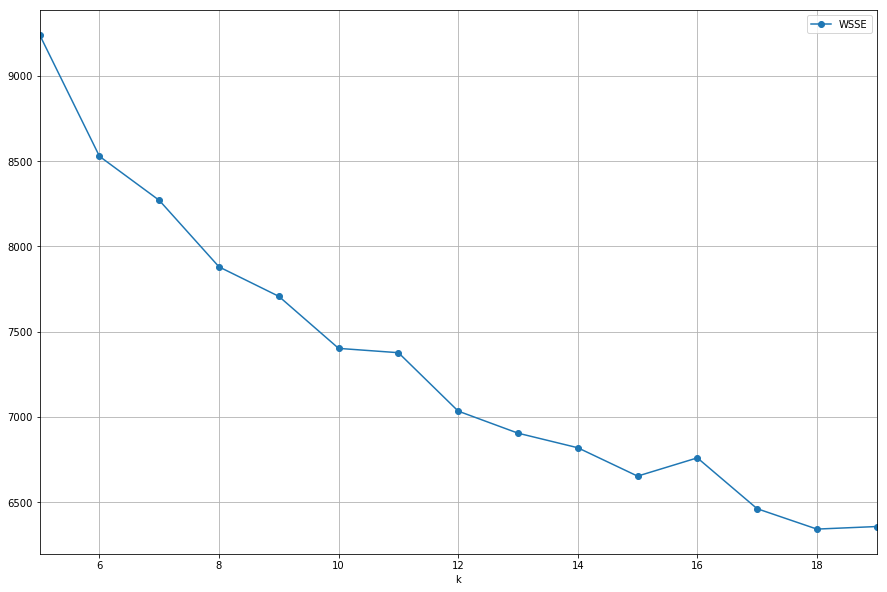

In [14]:
utils.elbow_plot(wsseList, clusters)

In [15]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [16]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [17]:
centers = model.clusterCenters()
centers

[array([ 1.39821871, -0.07775022, -1.13721491, -0.09000213, -0.99763889,
        -0.06894974, -0.99847933]),
 array([-0.66703713, -1.28648334,  0.40414454,  0.62430116,  0.5123885 ,
         0.61009897,  1.36479118]),
 array([-0.05912633,  0.64291965,  0.23392548, -0.62611371,  0.41056116,
        -0.63587996, -0.49727124]),
 array([-0.20977681,  0.63250875,  0.41835553,  0.67102275,  0.52960445,
         0.61127166, -0.19060131]),
 array([ 0.19994022,  0.83313097,  1.38762042, -0.64496221,  1.66250819,
        -0.60229412, -0.76193706]),
 array([-1.23956343, -0.81482095,  0.45445545,  2.01239573,  0.54723155,
         1.97188331,  0.8624963 ]),
 array([-0.18137494,  0.85706207, -1.2890726 , -0.58042986, -1.15026084,
        -0.59457453, -0.63114369]),
 array([-0.86867934, -0.70072507,  0.2653508 , -0.54462649,  0.41020329,
        -0.54652744,  1.09440765]),
 array([ 0.66299432, -0.9961146 ,  0.83206945, -0.45249941,  1.02667501,
        -0.42805013,  1.00020351]),
 array([ 0.2258722 

In [18]:
P = utils.pd_centers(featuresUsed, centers)

## Dry Days

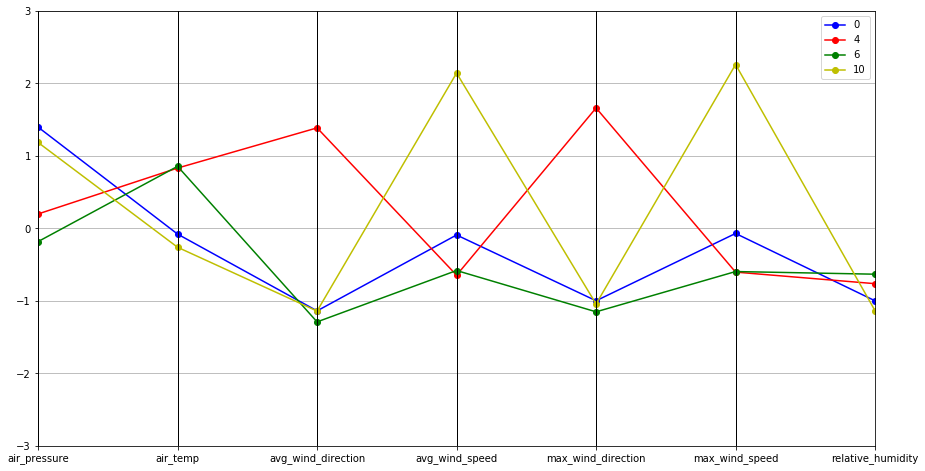

In [19]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

## Warm Days

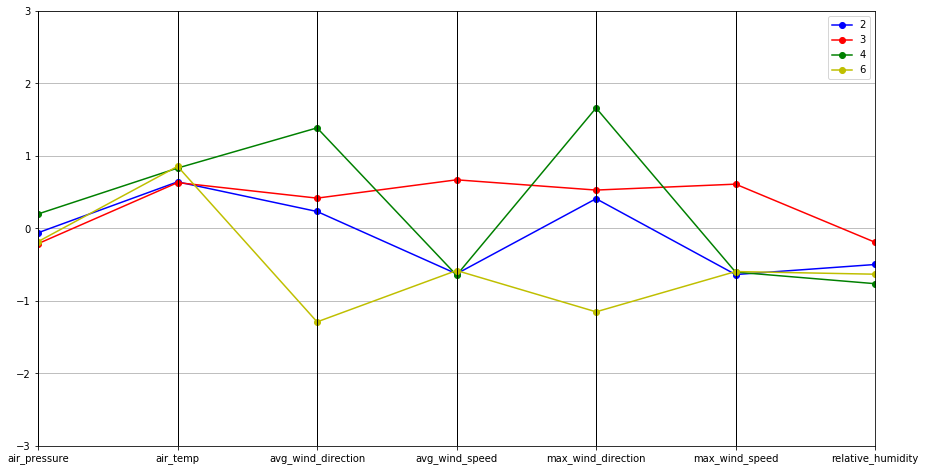

In [20]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

## Cool Days

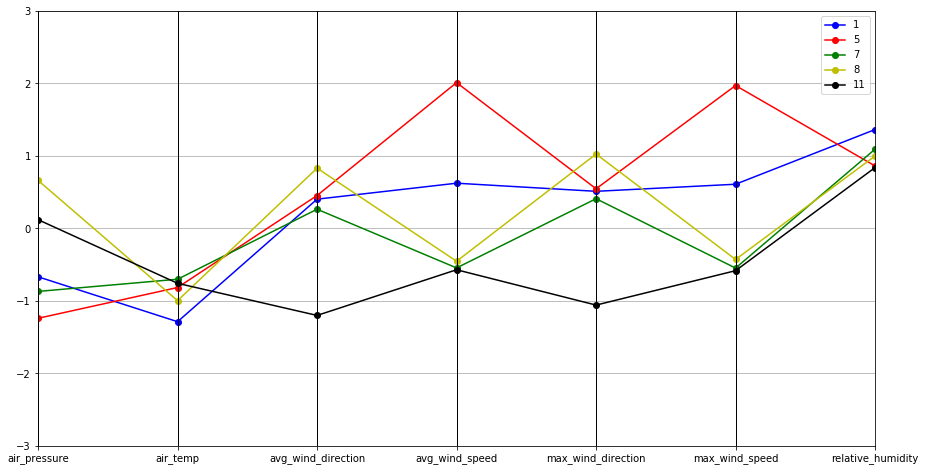

In [21]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

## Other Days

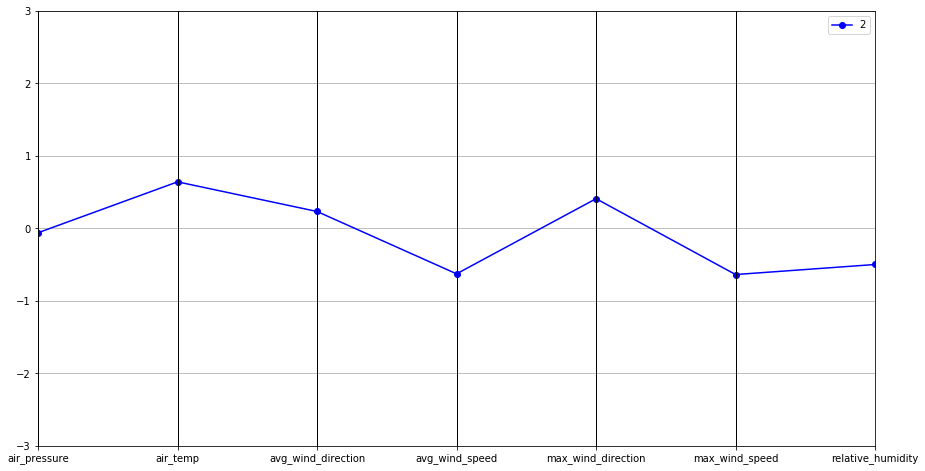

In [22]:
utils.parallel_plot(P.iloc[[2]], P)